# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.linear_model import LogisticRegression
from interpret import show
%matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.max_rows', 100)

In [2]:
os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/model_training/')
from ensemble_train import *

os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/model_explanation/')
from ensemble_explanation import show_feature_weights

os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/model_evaluation/')
from ensemble_evaluation import compare_ensembles_rocs_on_dataset,calculate_rocs_on_datasets,calculate_metrics_on_datasets,calculate_experiment_performance_on_datasets

os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/data_preprocessing')
from ensemble_preprocessing import execute_ensemble_preprocessing

os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/data_preparation')
from ensemble_preparation import execute_ensemble_preparation

In [3]:
def show_global_interpretation(ebm,lr,features_lr,features_ebm = None):
    
    if features_ebm is None:
        features_ebm = ebm.feature_names
    feature_importances = ebm.feature_importances_
    show_feature_weights(features_ebm,feature_importances,'EBM',figsize=(6,6), absolute_values = False,normalized=True)

    feature_importances = lr.coef_.ravel()
    show_feature_weights(features_lr,feature_importances,'Logistic Regression', color = ('r','g'),figsize=(6,6), absolute_values = False,normalized=True)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


def plot_global_explanations(features_lr,coefficients_lr,features_ebm,coefficients_ebm,title,
                            normalized=True,figsize=(9,4),top_features=10,vertical_space=0.85,horizontal_space=0.85):
    df_weights_lr = prepare_feature_importance(features_lr,coefficients_lr)
    df_weights_ebm = prepare_feature_importance(features_ebm,coefficients_ebm)
    
    if normalized:
        column = 'normalized'
    else:
        column = 'Weights'
        
    if top_features is not None:
        df_weights_lr = df_weights_lr.iloc[-top_features:]
        df_weights_ebm = df_weights_ebm.iloc[-top_features:]

    fig,ax = plt.subplots(1,2,figsize=figsize)
    color = ('r','g')
    colors = (0.2,0.4,0.8)

    if color is not None:
        color_mask = df_weights_lr['normalized'] > 0
        colors = [color[0] if c else color[1] for c in color_mask]
        legend_elements = [
            Patch(facecolor = color[1], edgecolor='k', label='Negative Contribution'),
            Patch(facecolor = color[0], edgecolor='k', label='Positive Contribution')]

    ax[0].tick_params(axis = 'both',labelsize = 'large')
    ax[1].tick_params(axis = 'both',labelsize = 'large')
    df_weights_lr[column].plot(kind = 'barh',title='LR', grid = True, color = colors,edgecolor='k', alpha = 0.6,ax = ax[0])
    df_weights_ebm[column].plot(kind = 'barh',title='EBM', grid = True,edgecolor='k', alpha = 0.6,ax = ax[1])

    plt.grid(True)
    fig.suptitle('Global Explanations - '+title,fontsize = 20,x=0.45)

    if color:
        ax[0].legend(handles=legend_elements, bbox_to_anchor=(1, -0.05), borderaxespad=0.,fancybox=True, shadow=True,ncol = 2)

    plt.subplots_adjust(top=vertical_space, bottom=0, left=0.10, right=0.95, hspace=0.40, wspace=horizontal_space)
    plt.show()
    return fig

def prepare_feature_importance(features,coefficients):
    df_weights = create_normalized_by_feature_weight(features,coefficients);
    
    df_weights = df_weights.sort_values(by=['abs_Weights'],ascending = True,inplace = False)
    return df_weights

def create_normalized_by_feature_weight(features,coefficients):
    
    '''
        Create a Dataframe based on the Weights given to each feature by linear models, with the following columns:
          Weights: Weights of each feature
          abs_Weights: Absolute value of the weights
          normalized: Normalized weights (all values of this column add up to one)
          abs_normalized: Absolute value of the feature importance
      
        Parameters:
          features: 1-D array with the feature names
          coefficients: 1-D array values of weights given to features.
    '''

    df_weights = pd.DataFrame(index = features,columns = ['Weights'])
    df_weights['Weights'] = coefficients
    df_weights['abs_Weights'] = np.abs(df_weights['Weights'])
    total_weights = df_weights['abs_Weights'].values.ravel().sum()
    df_weights['normalized'] = df_weights['Weights'].values / total_weights
    df_weights['abs_normalized'] = df_weights['abs_Weights'].values / total_weights
    df_weights.sort_values(by=['abs_normalized'],ascending = False,inplace = True)
    return df_weights


# Cog Tests Experiment

In [5]:
def process_cognitive_data(preprocessed_cognitive_data_path,processed_ensemble_data_path,labels,cols_to_drop):
  df_cog_data = pd.read_csv(preprocessed_cognitive_data_path).dropna()
  df_ensemble_processed = pd.read_csv(processed_ensemble_data_path)

  df_cog_data.rename(columns={"IMAGEUID":"IMAGE_DATA_ID"},inplace=True)
  df_cog_data['IMAGE_DATA_ID'] = 'I' + df_cog_data['IMAGE_DATA_ID'].astype(str)
  df_cog_data = df_cog_data.merge(df_ensemble_processed[['IMAGE_DATA_ID','DATASET']],on='IMAGE_DATA_ID',how='left').query("DIAGNOSIS in @labels").reset_index(drop=True)
  
  if max(labels) == 2:
    # replace 2 (MCI) for 1 for binary classification 
    df_cog_data['DIAGNOSIS'].replace({2:1},inplace=True)
  df_cog_data.sort_values(['DATASET',"SUBJECT",'IMAGE_DATA_ID','VISCODE','RID'],inplace=True)
  df_cog_data = df_cog_data.drop(cols_to_drop,axis=1)
  return df_cog_data

def get_cognitive_data_predictions(df_cog_data):
  df_train = df_cog_data.query("DATASET not in ('validation','test')").drop(['RID','SUBJECT','VISCODE','SITE',
                                                                          'COLPROT','ORIGPROT','EXAMDATE','IMAGE_DATA_ID',
                                                                          'DIAGNOSIS_BASELINE','RACE','DATASET'],axis=1)
  
  ebm_cog = ExplainableBoostingClassifier();
  ebm_cog.fit(df_train.drop('DIAGNOSIS',axis=1),df_train['DIAGNOSIS']);
  
  lr_cog = LogisticRegression(max_iter=5000);
  lr_cog.fit(df_train.drop('DIAGNOSIS',axis=1),df_train['DIAGNOSIS']);

  df_cog_final = df_cog_data.drop(['SITE','COLPROT','ORIGPROT','EXAMDATE','DIAGNOSIS_BASELINE','RACE'],axis=1)
  ebm_preds = ebm_cog.predict_proba(df_cog_final.drop(['DIAGNOSIS','DATASET',"SUBJECT",'IMAGE_DATA_ID','VISCODE','RID'],axis=1))[:,-1]
  lr_preds = lr_cog.predict_proba(df_cog_final.drop(['DIAGNOSIS','DATASET',"SUBJECT",'IMAGE_DATA_ID','VISCODE','RID'],axis=1))[:,-1]
  
  df_cog_final['COGTEST_SCORE_EBM'] = ebm_preds
  df_cog_final['COGTEST_SCORE_LR'] = lr_preds
  
  return df_cog_final,ebm_cog,lr_cog

## ADxCN

In [6]:
preprocessed_cognitive_data_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/COGNITIVE_DATA_PREPROCESSED.csv'
processed_ensemble_data_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PROCESSED_ENSEMBLE_REFERENCE.csv'
cognitive_data_predictions_final_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_AD_COG_TESTS.csv'
classes = [0,1]

df_cog_data = process_cognitive_data(preprocessed_cognitive_data_path,processed_ensemble_data_path,labels=classes,cols_to_drop = ['MARRIED','DIVORCED','NEVER_MARRIED'])
df_cog_final,ebm_cog,lr_cog = get_cognitive_data_predictions(df_cog_data)

In [7]:
label = 'DIAGNOSIS'
df_train = df_cog_final.query("DATASET not in ('validation','test')").drop(['COGTEST_SCORE_EBM','COGTEST_SCORE_LR','DATASET',"SUBJECT",'IMAGE_DATA_ID','VISCODE','RID'],axis=1).fillna(0)
df_validation = df_cog_final.query("DATASET in ('validation')").drop(['COGTEST_SCORE_EBM','COGTEST_SCORE_LR','DATASET',"SUBJECT",'IMAGE_DATA_ID','VISCODE','RID'],axis=1).fillna(0)
df_test = df_cog_final.query("DATASET in ('test')").drop(['COGTEST_SCORE_EBM','COGTEST_SCORE_LR','DATASET',"SUBJECT",'IMAGE_DATA_ID','VISCODE','RID'],axis=1).fillna(0)

models=[ebm_cog,lr_cog]
datasets=[df_train,df_validation,df_test]
df_cog_final['COGTEST_SCORE'] = df_cog_final['COGTEST_SCORE_LR']

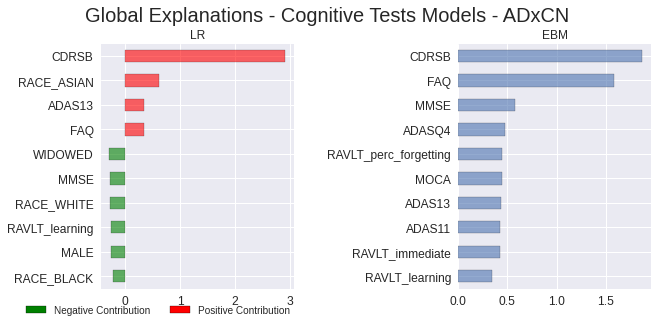

In [8]:
fig = plot_global_explanations(features_lr = df_test.columns[1:],
        coefficients_lr = lr_cog.coef_.ravel(),
        features_ebm = ebm_cog.feature_names,
        coefficients_ebm = ebm_cog.feature_importances_,
        title = 'Cognitive Tests Models - ADxCN',
        normalized=False,
        top_features=10)

## MCIxCN

In [9]:
preprocessed_cognitive_data_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/COGNITIVE_DATA_PREPROCESSED.csv'
processed_ensemble_data_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PROCESSED_ENSEMBLE_REFERENCE.csv'
cognitive_data_predictions_final_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_MCI_COG_TESTS.csv'
classes = [0,2]

df_cog_data = process_cognitive_data(preprocessed_cognitive_data_path,processed_ensemble_data_path,labels=classes,cols_to_drop = ['MARRIED','DIVORCED','NEVER_MARRIED'])
df_cog_final,ebm_cog,lr_cog = get_cognitive_data_predictions(df_cog_data)

In [10]:
label = 'DIAGNOSIS'
df_train = df_cog_final.query("DATASET not in ('validation','test')").drop(['COGTEST_SCORE_EBM','COGTEST_SCORE_LR','DATASET',"SUBJECT",'IMAGE_DATA_ID','VISCODE','RID'],axis=1).fillna(0)
df_validation = df_cog_final.query("DATASET in ('validation')").drop(['COGTEST_SCORE_EBM','COGTEST_SCORE_LR','DATASET',"SUBJECT",'IMAGE_DATA_ID','VISCODE','RID'],axis=1).fillna(0)
df_test = df_cog_final.query("DATASET in ('test')").drop(['COGTEST_SCORE_EBM','COGTEST_SCORE_LR','DATASET',"SUBJECT",'IMAGE_DATA_ID','VISCODE','RID'],axis=1).fillna(0)

models=[ebm_cog,lr_cog]
datasets=[df_train,df_validation,df_test]
df_cog_final['COGTEST_SCORE'] = df_cog_final['COGTEST_SCORE_LR']

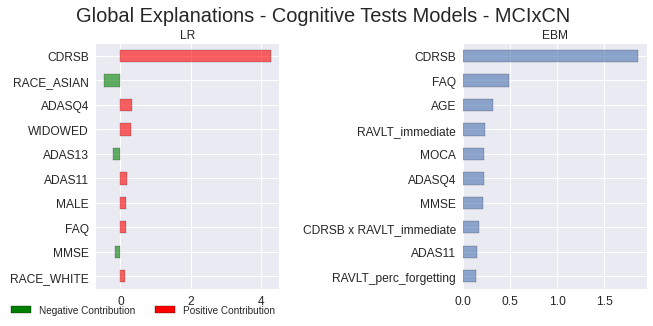

In [11]:
fig = plot_global_explanations(features_lr = df_test.columns[1:],
        coefficients_lr = lr_cog.coef_.ravel(),
        features_ebm = ebm_cog.feature_names,
        coefficients_ebm = ebm_cog.feature_importances_,
        title = 'Cognitive Tests Models - MCIxCN',
        figsize=(9,4),
        vertical_space=0.85,
        normalized=False,
        horizontal_space=1,
        top_features=10)

# Ensemble Experiments

## ADxCN

In [12]:
# mri_data_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_MCI_VGG19_BN_1125.csv'
# cognitive_data_predictions_final_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_MCI_COG_TESTS_1125.csv'

mri_data_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_AD_VGG19_BN.csv'
cognitive_data_predictions_final_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_AD_COG_TESTS.csv'

df_mri = prepare_mri_predictions(mri_data_path)
df_ensemble = prepare_ensemble_experiment_set(cognitive_data_predictions_final_path,mri_data_path)

In [13]:
df_ensemble.columns = ['SUBJECT', 'DATASET', 'AXIAL_23', 'CORONAL_43','SAGITTAL_26', 'COGTEST', 'DIAGNOSIS']

### Experiment 1 using 3 CNNs

In [14]:
df_train,df_validation,df_test = get_experiment_sets(df_ensemble,cols_to_drop = ['SUBJECT','DATASET','COGTEST'])

datasets=[df_train,df_validation,df_test]
label = 'DIAGNOSIS'
ebm,lr = ExplainableBoostingClassifier(),LogisticRegression()
models = [ebm,lr]

models = train_ensemble_models(df_train,label,models)

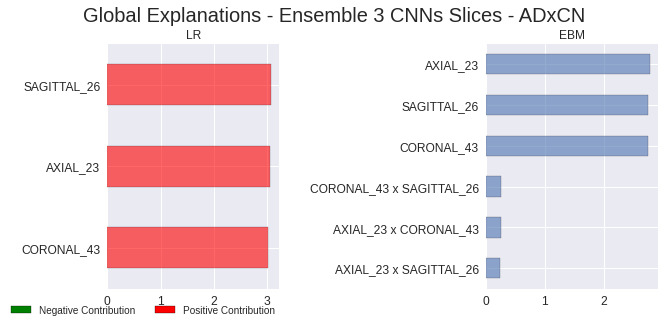

In [15]:
figure = plot_global_explanations(features_lr = df_test.columns[:-1],
        coefficients_lr = lr.coef_.ravel(),
        features_ebm = ebm.feature_names,
        coefficients_ebm = ebm.feature_importances_,
        title = 'Ensemble 3 CNNs Slices - ADxCN',
        normalized=False,
        top_features=10,
        horizontal_space=1.2)

### Experiment 2 using 3 CNNs + Demographics

In [16]:
demographic_cols = ['AGE','MALE',
                    'YEARS_EDUCATION','HISPANIC',
                    'RACE_WHITE', 'RACE_BLACK', 'RACE_ASIAN', 'WIDOWED']
df_cog_final = pd.read_csv(cognitive_data_predictions_final_path).set_index("IMAGE_DATA_ID")
df_ensemble_demographics = df_cog_final[demographic_cols].merge(df_ensemble,right_index=True,left_index=True)

df_train,df_validation,df_test = get_experiment_sets(df_ensemble_demographics,cols_to_drop = ['SUBJECT','DATASET','COGTEST'])

datasets=[df_train,df_validation,df_test]
label = 'DIAGNOSIS'
ebm,lr = ExplainableBoostingClassifier(),LogisticRegression(max_iter=1000)
models = [ebm,lr]
ebm,lr = train_ensemble_models(df_train,label,models)

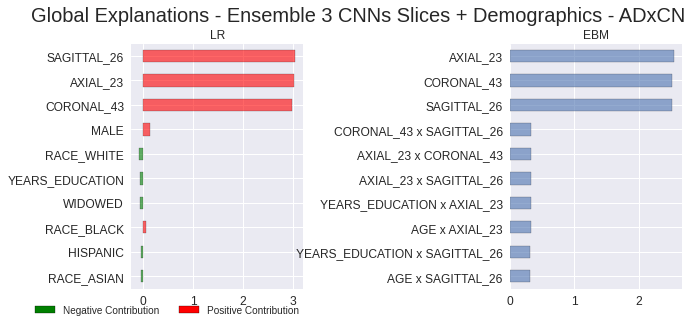

In [17]:
figure = plot_global_explanations(features_lr = df_test.columns[:-1],
        coefficients_lr = lr.coef_.ravel(),
        features_ebm = ebm.feature_names,
        coefficients_ebm = ebm.feature_importances_,
        title = 'Ensemble 3 CNNs Slices + Demographics - ADxCN',
        normalized=False,
        top_features=10,
        horizontal_space=1.2)

### Experiment 3 - 3 CNNs + Demographics + CDRSB

In [18]:
demographic_cols = ['AGE','MALE',
                    'YEARS_EDUCATION','HISPANIC','CDRSB',
                    'RACE_WHITE', 'RACE_BLACK', 'RACE_ASIAN', 'WIDOWED']
df_cog_final = pd.read_csv(cognitive_data_predictions_final_path).set_index("IMAGE_DATA_ID")
df_ensemble_demographics = df_cog_final[demographic_cols].merge(df_ensemble,right_index=True,left_index=True)

df_train,df_validation,df_test = get_experiment_sets(df_ensemble_demographics,cols_to_drop = ['SUBJECT','DATASET','COGTEST'])

datasets=[df_train,df_validation,df_test]
label = 'DIAGNOSIS'
ebm,lr = ExplainableBoostingClassifier(),LogisticRegression()
models = [ebm,lr]
ebm,lr = train_ensemble_models(df_train,label,models)


/home/lucas/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


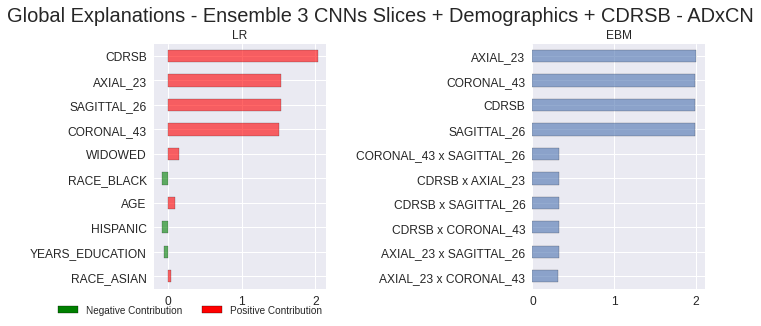

In [19]:
figure = plot_global_explanations(features_lr = df_test.columns[:-1],
        coefficients_lr = lr.coef_.ravel(),
        features_ebm = ebm.feature_names,
        coefficients_ebm = ebm.feature_importances_,
        title = 'Ensemble 3 CNNs Slices + Demographics + CDRSB - ADxCN',
        normalized=False,
        top_features=10,
        horizontal_space=1.2)

### Experiment4 using 3 CNNs + CognitiveTest Model

In [20]:
df_train,df_validation,df_test = get_experiment_sets(df_ensemble,cols_to_drop = ['SUBJECT','DATASET'])

datasets = [df_train,df_validation,df_test]
label = 'DIAGNOSIS'
ebm,lr = ExplainableBoostingClassifier(),LogisticRegression()
models = [ebm,lr]
ebm,lr = train_ensemble_models(df_train,label,models)

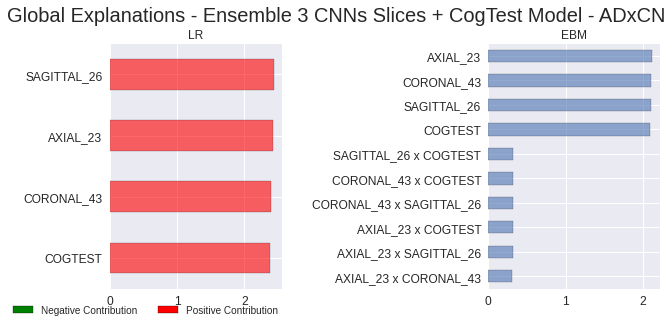

In [21]:
figure = plot_global_explanations(features_lr = df_test.columns[:-1],
        coefficients_lr = lr.coef_.ravel(),
        features_ebm = ebm.feature_names,
        coefficients_ebm = ebm.feature_importances_,
        title = 'Ensemble 3 CNNs Slices + CogTest Model - ADxCN',
        normalized=False,
        top_features=15,
        horizontal_space=1.2)

## MCIxCN

In [22]:
mri_data_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_MCI_VGG19_BN.csv'
cognitive_data_predictions_final_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_MCI_COG_TESTS.csv'

df_mri = prepare_mri_predictions(mri_data_path)
df_ensemble = prepare_ensemble_experiment_set(cognitive_data_predictions_final_path,mri_data_path)

In [23]:
df_ensemble.columns = ['SUBJECT', 'DATASET', 'AXIAL_8', 'CORONAL_70','SAGITTAL_50', 'COGTEST', 'DIAGNOSIS']

### Experiment 1 using 3 CNNs

In [32]:
df_train,df_validation,df_test = get_experiment_sets(df_ensemble,cols_to_drop = ['SUBJECT','DATASET','COGTEST'])

datasets=[df_train,df_validation,df_test]
label = 'DIAGNOSIS'
ebm,lr = ExplainableBoostingClassifier(),LogisticRegression()
models = [ebm,lr]

models = train_ensemble_models(df_train,label,models)

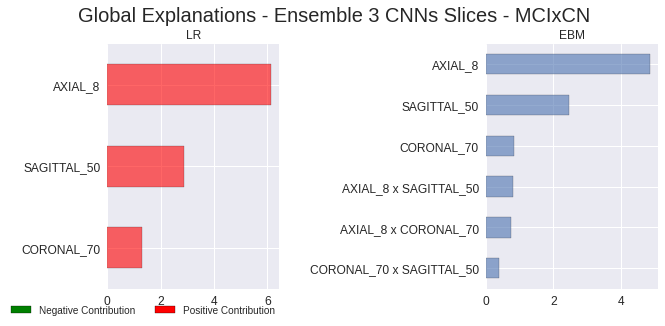

In [25]:
figure = plot_global_explanations(features_lr = df_test.columns[:-1],
        coefficients_lr = lr.coef_.ravel(),
        features_ebm = ebm.feature_names,
        coefficients_ebm = ebm.feature_importances_,
        title = 'Ensemble 3 CNNs Slices - MCIxCN',
        normalized=False,
        top_features=10,
        horizontal_space=1.2)

### Experiment 2 using 3 CNNs + Demographics

In [26]:
demographic_cols = ['AGE','MALE',
                    'YEARS_EDUCATION','HISPANIC',
                    'RACE_WHITE', 'RACE_BLACK', 'RACE_ASIAN', 'WIDOWED']
df_cog_final = pd.read_csv(cognitive_data_predictions_final_path).set_index("IMAGE_DATA_ID")
df_ensemble_demographics = df_cog_final[demographic_cols].merge(df_ensemble,right_index=True,left_index=True)

df_train,df_validation,df_test = get_experiment_sets(df_ensemble_demographics,cols_to_drop = ['SUBJECT','DATASET','COGTEST'])

datasets=[df_train,df_validation,df_test]
label = 'DIAGNOSIS'
ebm,lr = ExplainableBoostingClassifier(),LogisticRegression(max_iter=1000)
models = [ebm,lr]
ebm,lr = train_ensemble_models(df_train,label,models)

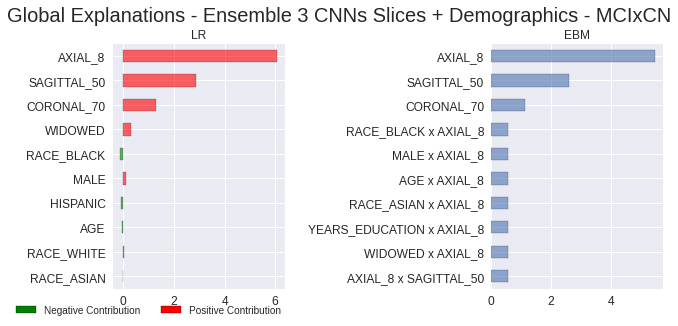

In [27]:
figure = plot_global_explanations(features_lr = df_test.columns[:-1],
        coefficients_lr = lr.coef_.ravel(),
        features_ebm = ebm.feature_names,
        coefficients_ebm = ebm.feature_importances_,
        title = 'Ensemble 3 CNNs Slices + Demographics - MCIxCN',
        normalized=False,
        top_features=10,
        horizontal_space=1.2)

### Experiment 3 - 3 CNNs + Demographics + CDRSB

In [28]:
demographic_cols = ['AGE','MALE',
                    'YEARS_EDUCATION','HISPANIC','CDRSB',
                    'RACE_WHITE', 'RACE_BLACK', 'RACE_ASIAN', 'WIDOWED']
df_cog_final = pd.read_csv(cognitive_data_predictions_final_path).set_index("IMAGE_DATA_ID")
df_ensemble_demographics = df_cog_final[demographic_cols].merge(df_ensemble,right_index=True,left_index=True)

df_train,df_validation,df_test = get_experiment_sets(df_ensemble_demographics,cols_to_drop = ['SUBJECT','DATASET','COGTEST'])

datasets=[df_train,df_validation,df_test]
label = 'DIAGNOSIS'
ebm,lr = ExplainableBoostingClassifier(),LogisticRegression()
models = [ebm,lr]
ebm,lr = train_ensemble_models(df_train,label,models)


/home/lucas/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


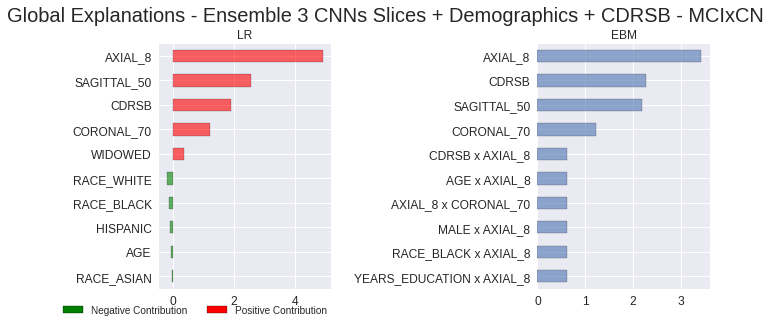

In [29]:
figure = plot_global_explanations(features_lr = df_test.columns[:-1],
        coefficients_lr = lr.coef_.ravel(),
        features_ebm = ebm.feature_names,
        coefficients_ebm = ebm.feature_importances_,
        title = 'Ensemble 3 CNNs Slices + Demographics + CDRSB - MCIxCN',
        normalized=False,
        top_features=10,
        horizontal_space=1.2)

### Experiment4 using 3 CNNs + CognitiveTest Model

In [30]:
df_train,df_validation,df_test = get_experiment_sets(df_ensemble,cols_to_drop = ['SUBJECT','DATASET'])

datasets = [df_train,df_validation,df_test]
label = 'DIAGNOSIS'
ebm,lr = ExplainableBoostingClassifier(),LogisticRegression()
models = [ebm,lr]
ebm,lr = train_ensemble_models(df_train,label,models)

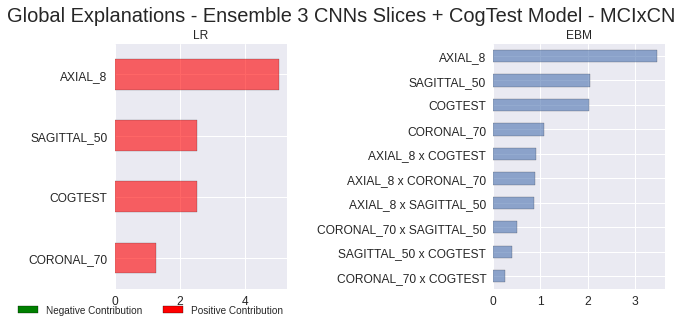

In [31]:
figure = plot_global_explanations(features_lr = df_test.columns[:-1],
        coefficients_lr = lr.coef_.ravel(),
        features_ebm = ebm.feature_names,
        coefficients_ebm = ebm.feature_importances_,
        title = 'Ensemble 3 CNNs Slices + CogTest Model - MCIxCN',
        normalized=False,
        top_features=10,
        horizontal_space=1.2)